## Hyperoxia and Organ Dysfunction
## C.V. Cosgriff for Team 11
## II MIT-HIAE Datathon

The overall goal is to assess the association between hyperoxia in the first 24 hours of mechanical ventilation and markers of organ dysfunction which, for this event, will be $\Delta$SOFA.

We will start by extracting out the base ICU cohort and then identifying the `itemid` that correspond to $SpO_2$ values.

__TODO:__ Change how SOFA day 1 and 2 are pulled in using the pivoted tables.

## 0 - Envrionment

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import statsmodels.formula.api as smf

import psycopg2
dbname = 'mimic'
schema_name = 'mimiciii'
db_schema = 'SET search_path TO {0};'.format(schema_name)
con = psycopg2.connect(database=dbname)

## 1 - Cohort Extraction

A lot of the desired concepts already exist from previous work either directly in the database or via materialized views. We will extract as much as we can this way.

In [2]:
query = db_schema + '''
-- note that this code uses a lot of local materialized veiws
-- the SQL queries for this will be loaded on the repository
-- and the views need to be built


-- TODO: combine this queries into one ventilator parameters query
--       as this is just a sloppy way with copy and pasting.

WITH tidal_volume_24h AS(
    WITH tidal_volume AS (
        SELECT ce.icustay_id, ce.charttime - ie.intime AS offset
        , ce.valuenum
        FROM icustays ie
        LEFT JOIN chartevents ce
            ON ie.icustay_id = ce.icustay_id
        WHERE ce.itemid = 224685
    )
    SELECT tv.icustay_id, MAX(tv.valuenum) AS tv_max_24h
    FROM tidal_volume tv
    WHERE tv.offset <= interval '24' hour
    GROUP BY tv.icustay_id
)
, peep_24h AS (
    WITH peep AS (
        SELECT ce.icustay_id, ce.charttime - ie.intime AS offset
        , ce.valuenum
        FROM icustays ie
        LEFT JOIN chartevents ce
            ON ie.icustay_id = ce.icustay_id
        WHERE ce.itemid = 220339
    )
    SELECT peep.icustay_id, MAX(peep.valuenum) AS peep_max_24h
    FROM peep
    WHERE peep.offset <= interval '24' hour
    GROUP BY peep.icustay_id
)
, fio2_24h AS(
    WITH fio2 AS (
        SELECT ce.icustay_id, ce.charttime - ie.intime AS offset
        , ce.valuenum
        FROM icustays ie
        LEFT JOIN chartevents ce
            ON ie.icustay_id = ce.icustay_id
        WHERE ce.itemid = 223835
    )
    SELECT fio2.icustay_id, MAX(fio2.valuenum) AS fio2_max_24h
    FROM fio2
    WHERE fio2.offset <= interval '24' hour
    GROUP BY fio2.icustay_id
)

SELECT ie.icustay_id, ie.hadm_id, ie.subject_id, ie.dbsource
       , ie.first_careunit, ie.intime, ie.outtime, ie.los
       , ied.admission_age, ied.gender, ied.ethnicity, v.resprate_max
       , tv.tv_max_24h, pp.peep_max_24h, fi.fio2_max_24h -- vent paramaters
       , ied.first_icu_stay, oa.oasis AS oasis_score
       , s1.sofa AS sofa_day1, s2.sofa AS sofa_day2
       , l1.lactate_max AS lactate_max_day1, l2.lactate_max AS lactate_max_day2
       , elixdx.congestive_heart_failure, elixdx.cardiac_arrhythmias --- start of comorbidities
       , elixdx.valvular_disease, elixdx.pulmonary_circulation
       , elixdx.peripheral_vascular, elixdx.hypertension
       , elixdx.paralysis, elixdx.other_neurological
       , elixdx.chronic_pulmonary, elixdx.diabetes_uncomplicated
       , elixdx.diabetes_complicated, elixdx.hypothyroidism
       , elixdx.renal_failure, elixdx.liver_disease
       , elixdx.peptic_ulcer, elixdx.aids
       , elixdx.lymphoma, elixdx.metastatic_cancer
       , elixdx.solid_tumor, elixdx.rheumatoid_arthritis
       , elixdx.coagulopathy, elixdx.obesity
       , elixdx.weight_loss, elixdx.fluid_electrolyte
       , elixdx.blood_loss_anemia, elixdx.deficiency_anemias
       , elixdx.alcohol_abuse, elixdx.drug_abuse
       , elixdx.psychoses, elixdx.depression -- end of comorbidities
       , elixscore.elixhauser_vanwalraven AS elixhauser_score -- score for comorbid
       , vd.starttime AS vent_start, vd.endtime AS vent_end
       , vd.duration_hours AS ventduration, ad.hospital_expire_flag
FROM icustays ie
LEFT JOIN icustay_detail ied
    ON ie.icustay_id = ied.icustay_id
LEFT JOIN admissions ad
    ON ie.hadm_id = ad.hadm_id
LEFT JOIN vitalsfirstday v
    ON ie.icustay_id = v.icustay_id
LEFT JOIN labsfirstday l1
    ON ie.icustay_id = l1.icustay_id
LEFT JOIN labssecondday l2
    ON ie.icustay_id = l2.icustay_id
LEFT JOIN tidal_volume_24h tv
    ON ie.icustay_id = tv.icustay_id
LEFT JOIN peep_24h pp
    ON ie.icustay_id = pp.icustay_id
LEFT JOIN fio2_24h fi
    ON ie.icustay_id = fi.icustay_id
LEFT JOIN elixhauser_ahrq_score elixscore
    ON ie.hadm_id = elixscore.hadm_id
LEFT JOIN elixhauser_ahrq_no_drg_all_icd elixdx
    ON ie.hadm_id = elixdx.hadm_id
LEFT JOIN oasis oa
    ON ie.icustay_id = oa.icustay_id
LEFT JOIN sofa_firstday s1
    ON ie.icustay_id = s1.icustay_id
LEFT JOIN sofa_secondday s2
    ON ie.icustay_id = s2.icustay_id
LEFT JOIN ventdurations vd
    ON ie.icustay_id = vd.icustay_id
    AND vd.ventnum = 1 -- we only take first vent period because we only care about first 24 hour
WHERE ie.dbsource = 'metavision';
'''
cohort_df = pd.read_sql(query, con)
print(cohort_df.shape)
display(cohort_df.head())

(23620, 56)


,icustay_id,hadm_id,subject_id,dbsource,first_careunit,intime,outtime,los,admission_age,gender,...,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression,elixhauser_score,vent_start,vent_end,ventduration,hospital_expire_flag
0,275225,100001,58526,metavision,MICU,2117-09-11 11:47:35,2117-09-15 17:57:14,4.2567,35.4765,F,...,0,0,0,0,0,5,NaT,NaT,NaN,0
1,209281,100003,54610,metavision,MICU,2150-04-17 15:35:42,2150-04-19 14:12:52,1.9425,59.9127,M,...,0,0,0,0,0,11,NaT,NaT,NaN,0
2,253656,100009,533,metavision,CSRU,2162-05-17 10:18:31,2162-05-19 22:05:14,2.4908,60.7971,M,...,1,0,0,0,0,-4,2162-05-17 18:00:00,2162-05-17 22:45:00,4.75,0
3,271147,100010,55853,metavision,SICU,2109-12-10 21:58:01,2109-12-12 12:13:20,1.5940,54.5208,F,...,0,0,0,0,0,17,NaT,NaT,NaN,0
4,214619,100011,87977,metavision,TSICU,2177-08-29 04:52:21,2177-09-09 16:56:35,11.5029,21.5041,M,...,0,0,1,0,0,-7,2177-08-29 05:00:00,2177-09-07 03:00:00,214.00,0


We'll do a quick missingness check for sanity.

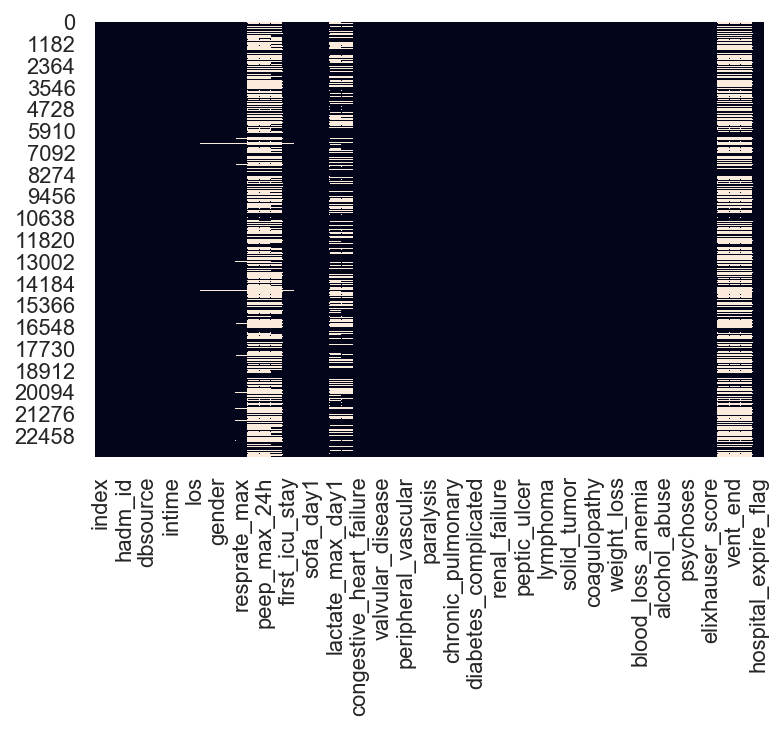

In [3]:
sns.heatmap(cohort_df.reset_index().isna(), cbar=False)

This pattern of missingness seems reasonable; patients missing vent start/end are missing vent parameters because they likely weren't on the ventilator.

## 2 - Extracting $SpO_2$ and Feature Engineering Hyperoxic Time

We start by identifying the metavision ID for $SpO_2$.

In [4]:
query = db_schema + '''
SELECT itemid, label, dbsource, linksto 
FROM d_items 
WHERE LOWER(label) LIKE '%o2%'
AND dbsource='metavision';
'''

d_search = pd.read_sql_query(query, con)
display(d_search)

,itemid,label,dbsource,linksto
0,228640,EtCO2,metavision,chartevents
1,228641,EtCO2 Clinical indication,metavision,chartevents
2,227060,Use A-aDO2,metavision,chartevents
3,227287,O2 Flow (additional cannula),metavision,chartevents
4,226860,RA %O2 Saturation (PA Line),metavision,chartevents
5,226861,ART %O2 saturation (PA Line),metavision,chartevents
6,226862,PA %O2 Saturation (PA Line),metavision,chartevents
7,226863,PVR %O2 Saturation (PA Line),metavision,chartevents
8,226865,SVR %O2 Saturation (PA Line),metavision,chartevents
9,226983,Apache IV A-aDO2,metavision,chartevents


It is `itemid` 2202777. We then extract all of these values from `chartevents` in the interval [0, 24h].

In [5]:
query = db_schema + '''
WITH spo2_day1 AS (
    SELECT ce.icustay_id, ce.charttime - ie.intime AS offset
    , ce.value
    FROM icustays ie
    LEFT JOIN chartevents ce
        ON ie.icustay_id = ce.icustay_id
    WHERE ce.itemid = 220277
)
SELECT sp.icustay_id, sp.value AS spo2_24h, sp.offset
FROM spo2_day1 sp
WHERE sp.offset <= interval '24' hour
AND sp.offset >= interval '0' hour
ORDER BY sp.offset ASC;
'''

sp_df = pd.read_sql(query, con)
display(sp_df.head())

,icustay_id,spo2_24h,offset
0,269515,100,0 days
1,261355,91,0 days
2,282785,97,0 days
3,253466,100,0 days
4,232470,100,0 days


After which we do some brief data cleaning.

In [6]:
sp_df.spo2_24h = sp_df.spo2_24h.astype(float)
sp_df = sp_df.loc[sp_df.spo2_24h <= 100, :]

We can visualize an example $SpO_2$ trend.

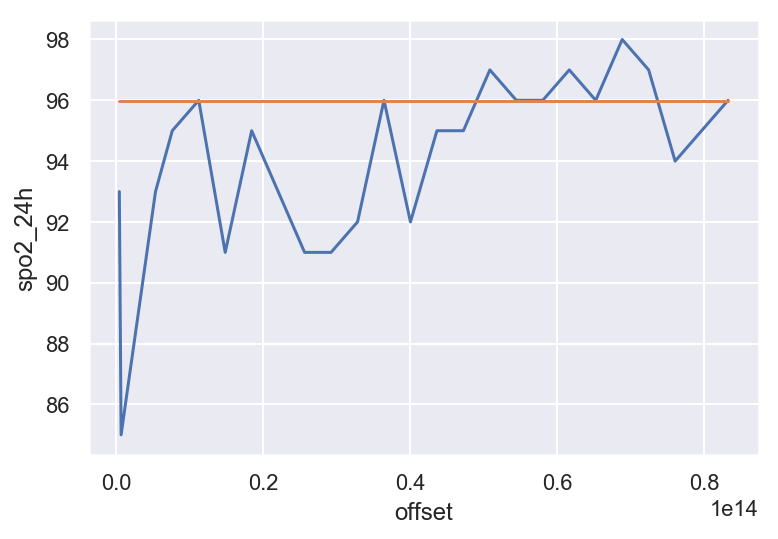

In [7]:
example_patient = sp_df.loc[sp_df.icustay_id == 241249, :].copy()
example_patient.loc[:, 'offset'] = example_patient.offset / np.timedelta64(1, 'ns')
example_patient.loc[:, 'spo2_24h'] = example_patient.spo2_24h.astype(float)
sns.lineplot(x=example_patient.offset, y=example_patient.spo2_24h)
sns.lineplot(x=[example_patient.offset.min(), example_patient.offset.max()], y=[95.99,95.99])
plt.savefig('example1.png')

We will want to integrate the peaks above the line designating normoxia; we can visualize this first.

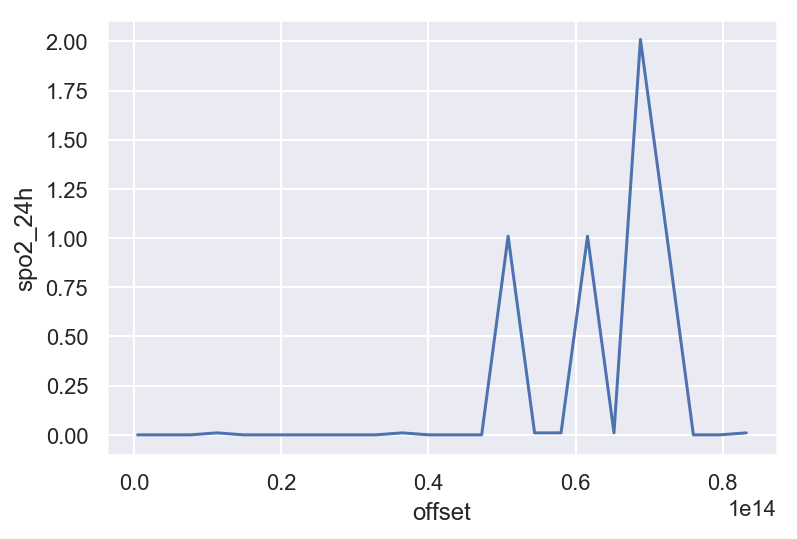

In [8]:
example_patient.loc[:, 'spo2_24h'] = example_patient.spo2_24h - 95.99
example_patient.loc[example_patient.spo2_24h < 0, 'spo2_24h'] = 0
sns.lineplot(x=example_patient.offset, y=example_patient.spo2_24h)
plt.savefig('example2.png')

We will write a function to integrate the area under these peaks for each patient.

In [9]:
def hyperoxic_time(time, spo2):
    spo2 = spo2 - 95.99
    spo2[spo2 < 0] = 0
    if (spo2 > 0).any():
        return np.trapz(y=spo2, x=time) / np.timedelta64(1, 'ns') / (3.6*10**12)
    else:
        return 0
    
hyperoxia_24h = [(i, hyperoxic_time(sp_df.loc[sp_df.icustay_id == i, 'offset'], sp_df.loc[sp_df.icustay_id == i, 'spo2_24h']))\
                   for i in sp_df.icustay_id.unique()]

hyperoxia_24h = pd.DataFrame(hyperoxia_24h)
hyperoxia_24h = hyperoxia_24h.rename({0 : 'icustay_id', 1 : 'hyperoxia_24h'}, axis=1)

hyperoxia_24h.head()

,icustay_id,hyperoxia_24h
0,269515,70.576500
1,261355,11.252000
2,282785,44.944000
3,253466,51.169833
4,232470,24.663000


We then visualize the distribution of hyperoxic time in the first 24 hours to see if the result seems reasonable.

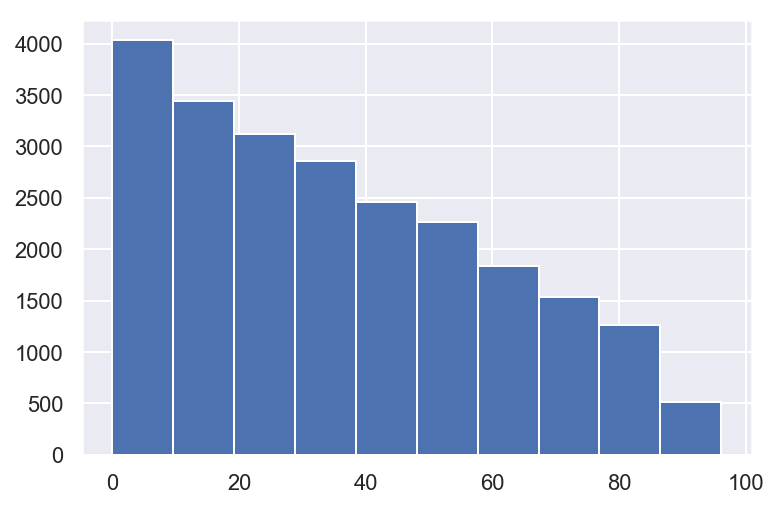

In [10]:
hyperoxia_24h.hyperoxia_24h.hist()

We then add this feature to our cohort data.

In [11]:
cohort_df = cohort_df.merge(right=hyperoxia_24h, how='left', on='icustay_id')
print(cohort_df.shape)
display(cohort_df.head())

(23620, 57)


,icustay_id,hadm_id,subject_id,dbsource,first_careunit,intime,outtime,los,admission_age,gender,...,alcohol_abuse,drug_abuse,psychoses,depression,elixhauser_score,vent_start,vent_end,ventduration,hospital_expire_flag,hyperoxia_24h
0,275225,100001,58526,metavision,MICU,2117-09-11 11:47:35,2117-09-15 17:57:14,4.2567,35.4765,F,...,0,0,0,0,5,NaT,NaT,NaN,0,33.023000
1,209281,100003,54610,metavision,MICU,2150-04-17 15:35:42,2150-04-19 14:12:52,1.9425,59.9127,M,...,0,0,0,0,11,NaT,NaT,NaN,0,57.823167
2,253656,100009,533,metavision,CSRU,2162-05-17 10:18:31,2162-05-19 22:05:14,2.4908,60.7971,M,...,0,0,0,0,-4,2162-05-17 18:00:00,2162-05-17 22:45:00,4.75,0,13.567833
3,271147,100010,55853,metavision,SICU,2109-12-10 21:58:01,2109-12-12 12:13:20,1.5940,54.5208,F,...,0,0,0,0,17,NaT,NaT,NaN,0,76.070083
4,214619,100011,87977,metavision,TSICU,2177-08-29 04:52:21,2177-09-09 16:56:35,11.5029,21.5041,M,...,0,1,0,0,-7,2177-08-29 05:00:00,2177-09-07 03:00:00,214.00,0,85.123333


This looks how we would expect. The next steps are joining this feature to the cleaning, exploration, and ultimately model building.

## 3 - Exploration and Cleaning

General Plan:
* Calculate $\Delta$SOFA
* Exclude patients with no SOFA on the second day / no $\Delta$SOFA (same difference)
* Exclude everyone younger than 16
* Exclude $F_iO_2$ $\leq$ 21%
* Require 24 hours on vent and vent start within 4 hours of ICU admission
* Use only first ICU stay
* Fix the ages greater than 89 (which are converted to 300 for HIPPA)
* Code gender as binary
* Limit our cohort to only patients who have been mechanically ventilated
* Build a simple model


__Problem:__ 
* It is unclear how best to model the $\Delta$SOFA; linear regression is not appropriate
* Alistair thinks the best approach would be Probit Ordered Regression
* This is not easily available in `Python` and we'll probably have to use `R`
* __Conclusion: For the datathon binarize around a positive $\Delta$SOFA and use Logistic Regression__

So we'll knock out the above todos, and then just viusalize the exposure variable (likely to not show much). Then we'll build a few simple models to present at the end.

In [12]:
delta_sofa = cohort_df.sofa_day2 - cohort_df.sofa_day1
cohort_df = cohort_df.assign(delta_sofa=delta_sofa)
eda_df = cohort_df.loc[~pd.isna(cohort_df.delta_sofa), :].copy()
eda_df.gender = (eda_df.gender == 'M').astype(int)
eda_df = eda_df.loc[cohort_df.admission_age >= 16, :]
eda_df.loc[eda_df.admission_age > 90, 'age'] = 91.3
eda_df = eda_df.loc[eda_df.los >= 0.167, :] # redundant because we require SOFA day 2
eda_df = eda_df.loc[eda_df.chronic_pulmonary == 0, :]
eda_df = eda_df.loc[eda_df.ventduration > 0, :]
eda_df = eda_df.loc[eda_df.fio2_max_24h > 21, :]
eda_df = eda_df.loc[eda_df.ventduration >= 24, :]
eda_df = eda_df.loc[eda_df.first_icu_stay, :]
vent_near_intime = (eda_df.vent_start < eda_df.intime + np.timedelta64('240', 'm')) | (eda_df.vent_start > eda_df.intime - np.timedelta64('240', 'm'))
eda_df = eda_df.loc[vent_near_intime, :]
label = (eda_df.delta_sofa > 0).astype(int)
eda_df = eda_df.assign(label=label)
print(eda_df.shape)

(2632, 60)


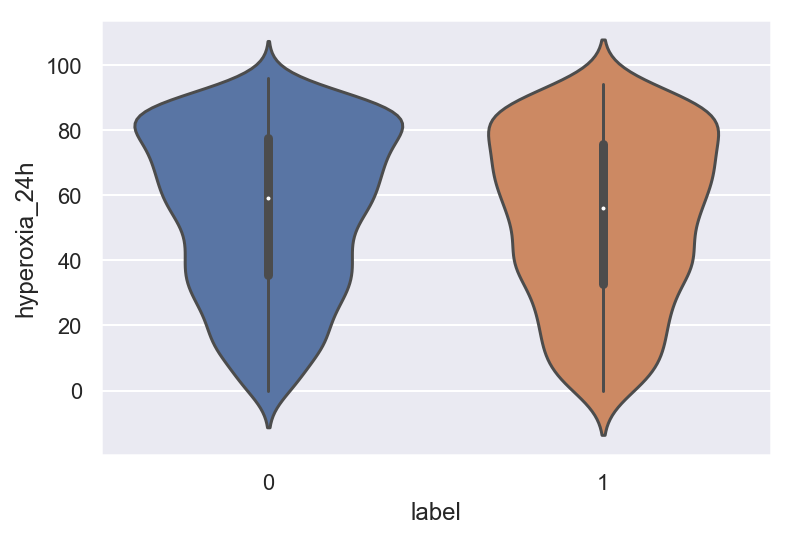

In [13]:
sns.violinplot(x='label', y='hyperoxia_24h', data=eda_df)

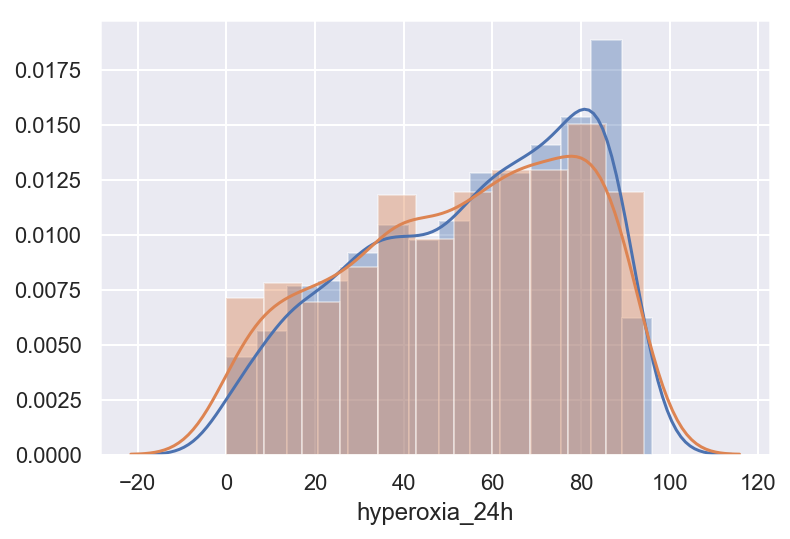

In [14]:
sns.distplot(a=eda_df.loc[eda_df.label == 0, 'hyperoxia_24h'].dropna())
sns.distplot(a=eda_df.loc[eda_df.label == 1, 'hyperoxia_24h'].dropna())

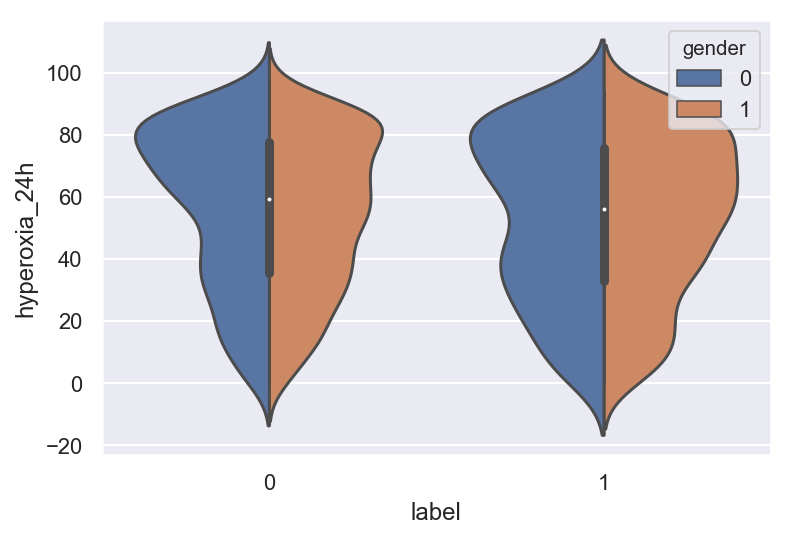

In [15]:
sns.violinplot(x='label', y='hyperoxia_24h', hue='gender', split=True, data=eda_df)

## 4 - Modeling

As said above, to do this for publication we'll need ordinal probit regression. For this event we'll binarize the $\Delta$SOFA outcome and sfit a logistic model for positive change in $\Delta$SOFA. We will also look at max lactate on the second day as a continuous outcome with OLS.

In [16]:
logit = smf.logit(formula='label ~ hyperoxia_24h', data=eda_df)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.619996
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 2632
Model:                          Logit   Df Residuals:                     2630
Method:                           MLE   Df Model:                            1
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                0.001514
Time:                        11:33:05   Log-Likelihood:                -1631.8
converged:                       True   LL-Null:                       -1634.3
                                        LLR p-value:                   0.02609
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.5912      0.098     -6.048      0.000      -0.783      -0.400
hyperoxia_24h    -0.0037      0.002     -2.227      0.026      -0.007      -0.000
=================================================================================
"""

In [17]:
logit = smf.logit(formula='label ~ hyperoxia_24h + admission_age + gender + oasis_score + elixhauser_score', data=eda_df)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.610536
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 2632
Model:                          Logit   Df Residuals:                     2626
Method:                           MLE   Df Model:                            5
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                 0.01675
Time:                        11:33:05   Log-Likelihood:                -1606.9
converged:                       True   LL-Null:                       -1634.3
                                        LLR p-value:                 1.470e-10
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6837      0.249      2.747      0.006       0.196       1.171
hyperoxia_24h       -0.0041      0.002     -2.465      0.014      -0.007      -0.001
admission_age        0.0005      0.001      0.627      0.531      -0.001       0.002
gender              -0.0045      0.088     -0.051      0.959      -0.176       0.167
oasis_score         -0.0375      0.006     -6.567      0.000      -0.049      -0.026
elixhauser_score     0.0173      0.005      3.197      0.001       0.007       0.028
====================================================================================
"""

In [18]:
logit = smf.logit(formula='label ~ hyperoxia_24h + admission_age + gender + oasis_score + elixhauser_score + resprate_max + peep_max_24h + tv_max_24h', data=eda_df)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.601547
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 2544
Model:                          Logit   Df Residuals:                     2535
Method:                           MLE   Df Model:                            8
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                 0.01461
Time:                        11:33:05   Log-Likelihood:                -1530.3
converged:                       True   LL-Null:                       -1553.0
                                        LLR p-value:                 3.130e-07
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5121      0.372      1.378      0.168      -0.216       1.240
hyperoxia_24h       -0.0036      0.002     -1.849      0.064      -0.007       0.000
admission_age        0.0005      0.001      0.566      0.572      -0.001       0.002
gender               0.0389      0.095      0.411      0.681      -0.147       0.224
oasis_score         -0.0345      0.006     -5.416      0.000      -0.047      -0.022
elixhauser_score     0.0143      0.006      2.572      0.010       0.003       0.025
resprate_max         0.0130      0.007      1.769      0.077      -0.001       0.027
peep_max_24h        -0.0456      0.015     -3.080      0.002      -0.075      -0.017
tv_max_24h       -7.659e-05      0.000     -0.254      0.800      -0.001       0.001
====================================================================================
"""

In [19]:
lm = smf.ols(formula='lactate_max_day2 ~ hyperoxia_24h', data=eda_df)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       lactate_max_day2   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.811
Date:                Sat, 27 Apr 2019   Prob (F-statistic):            0.00524
Time:                        11:33:05   Log-Likelihood:                -6087.3
No. Observations:                2413   AIC:                         1.218e+04
Df Residuals:                    2411   BIC:                         1.219e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.0743      0.144     28.304      0.000       3.792       4.357
hyperoxia_24h    -0.0067      0.002     -2.795      0.005      -0.011      -0.002
==============================================================================
Omnibus:                     1175.671   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7936.534
Skew:                           2.221   Prob(JB):                         0.00
Kurtosis:                      10.694   Cond. No.                         140.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
lm = smf.ols(formula='lactate_max_day2 ~ hyperoxia_24h + lactate_max_day1 + oasis_score + elixhauser_score + admission_age + gender', data=eda_df)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       lactate_max_day2   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     6962.
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:33:05   Log-Likelihood:                -2487.5
No. Observations:                2345   AIC:                             4989.
Df Residuals:                    2338   BIC:                             5029.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0486      0.085     -0.574      0.566      -0.215       0.118
hyperoxia_24h       -0.0018      0.001     -3.194      0.001      -0.003      -0.001
lactate_max_day1     1.0093      0.005    199.309      0.000       0.999       1.019
oasis_score          0.0060      0.002      3.171      0.002       0.002       0.010
elixhauser_score     0.0044      0.002      2.402      0.016       0.001       0.008
admission_age       -0.0002      0.000     -0.737      0.461      -0.001       0.000
gender              -0.0354      0.030     -1.184      0.236      -0.094       0.023
==============================================================================
Omnibus:                     3428.460   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           909754.104
Skew:                           8.823   Prob(JB):                         0.00
Kurtosis:                      97.866   Cond. No.                         637.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""